Implicit: 6486 parameters
Vanilla: 4613 parameters
Epoch 1/50
Implicit - Training Loss: 20.126153939819336, Validation Loss: 10.790866038513183
Vanilla - Training Loss: 25.32707312927246, Validation Loss: 13.016945390319824
Epoch 2/50
Implicit - Training Loss: 9.847224996948242, Validation Loss: 9.666420008850098
Vanilla - Training Loss: 10.847146817016602, Validation Loss: 9.636796823120116
Epoch 3/50
Implicit - Training Loss: 9.075559957885742, Validation Loss: 8.856441009521484
Vanilla - Training Loss: 8.97517989807129, Validation Loss: 8.72741471862793
Epoch 4/50
Implicit - Training Loss: 8.569434396362304, Validation Loss: 8.578841168212891
Vanilla - Training Loss: 8.363637867736816, Validation Loss: 8.330266770935058
Epoch 5/50
Implicit - Training Loss: 8.346423316955567, Validation Loss: 8.40792957458496
Vanilla - Training Loss: 8.02766736907959, Validation Loss: 8.0492907371521
Epoch 6/50
Implicit - Training Loss: 8.220420153808593, Validation Loss: 8.325611070251465
Vanilla - 

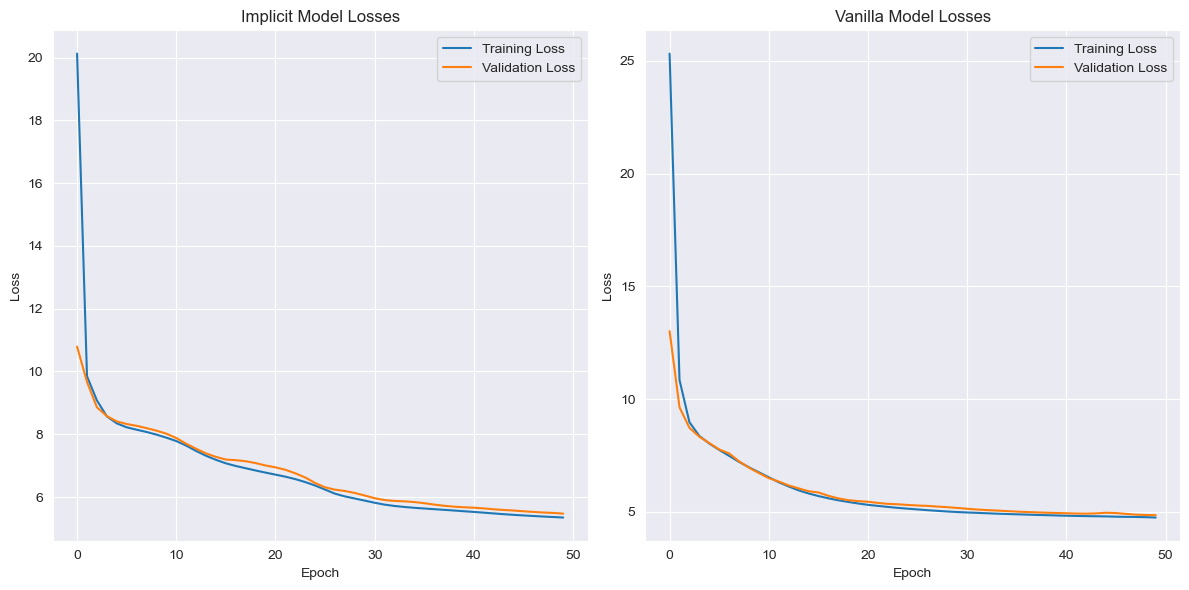

In [69]:
from torch.optim import lr_scheduler
from implicitdl import ImplicitModel
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
%matplotlib inline


# Vanilla Neural Network
class VanillaModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(VanillaModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        # self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Wrapper to unify the interface
class LinearSystemSolver(nn.Module):
    def __init__(self, model):
        super(LinearSystemSolver, self).__init__()
        self.model = model

    def forward(self, A, b):
        A_flat = A.view(A.size(0), -1)
        b_flat = b.view(b.size(0), -1)
        U = torch.cat((A_flat, b_flat), dim=1)
        return self.model(U)

# Generate synthetic data
N, d = 50000, 5
A_data, b_data = torch.rand(N, d, d) * 10, torch.rand(N, d, 1) * 10

# Create DataLoader
dataset = TensorDataset(A_data, b_data)
train_size = int(0.8 * N)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, N - train_size])
train_loader, val_loader = DataLoader(train_dataset, batch_size=512), DataLoader(val_dataset, batch_size=1024)

# Initialize models, loss, and optimizer
implicit_model = ImplicitModel(64, d * (d + 1), d)
vanilla_model = VanillaModel(d * (d + 1), 128, d)

models = {'Implicit': implicit_model, 'Vanilla': vanilla_model}
for name, model in models.items():
    print(f'{name}: {sum(p.numel() for p in model.parameters())} parameters')

implicit_solver, vanilla_solver = LinearSystemSolver(implicit_model), LinearSystemSolver(vanilla_model)
solver_names = {implicit_solver: 'Implicit', vanilla_solver: 'Vanilla'}
loss_fn = nn.MSELoss()
optimizers = [optim.Adam(solver.parameters(), lr=0.001) for solver in [implicit_solver, vanilla_solver]]
schedulers = [lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=10, threshold=0.01, factor=0.5, verbose=True) for opt in optimizers]

# Training loop
num_epochs = 50
train_losses, val_losses = {name: [] for name in models}, {name: [] for name in models}

for epoch in range(num_epochs):
    # Training phase
    for solver, optimizer in zip([implicit_solver, vanilla_solver], optimizers):
        solver.train()
        total_train_loss = 0.0

        for A_train_batch, b_train_batch in train_loader:
            optimizer.zero_grad()
            x_pred = solver(A_train_batch, b_train_batch).view(-1, d, 1)
            loss = loss_fn(torch.bmm(A_train_batch, x_pred), b_train_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * A_train_batch.size(0)

        train_losses[solver_names[solver]].append(total_train_loss / len(train_loader.dataset))

    # Validation phase
    with torch.no_grad():
        for solver, scheduler in zip([implicit_solver, vanilla_solver], schedulers):
            solver.eval()
            total_val_loss = 0.0

            for A_val_batch, b_val_batch in val_loader:
                x_pred = solver(A_val_batch, b_val_batch).view(-1, d, 1)
                loss = loss_fn(torch.bmm(A_val_batch, x_pred), b_val_batch)
                total_val_loss += loss.item() * A_val_batch.size(0)

            avg_val_loss = total_val_loss / len(val_loader.dataset)
            val_losses[solver_names[solver]].append(avg_val_loss)
            scheduler.step(avg_val_loss)

    # Print statistics
    print(f'Epoch {epoch+1}/{num_epochs}')
    for name in models:
        print(f'{name} - Training Loss: {train_losses[name][-1]}, Validation Loss: {val_losses[name][-1]}')

# Create plots
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses['Implicit'], label='Training Loss')
plt.plot(range(num_epochs), val_losses['Implicit'], label='Validation Loss')
plt.title('Implicit Model Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_losses['Vanilla'], label='Training Loss')
plt.plot(range(num_epochs), val_losses['Vanilla'], label='Validation Loss')
plt.title('Vanilla Model Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()